# TensorFlow

Here is a brief introduction to using TensorFlow (1.x). It includes multiple different ways to produce a simple linear regression. The first few methods were presented as examples, while I produced modifications to include: mini-batches, L1 and Elastic Net regularization, logistic regression (maybe). 

Each gradient descent essentially builds on the model before it, allowing for more or less granularity as you want. For example, you may wish to define your own loss functions, in which case the autograd method may be preferred over a built in optmizer. 

Courtesy of Mirko:

1. [Normal Equations with Numpy](#numpy) 
2. [Normal Equations with TensorFlow](#tfNormal)
3. [Gradient Descent with TF: Manual Gradients](#tfGDManual)
4. [Gradient Descent with TF: Auto Gradients](#tfGDAuto)
5. [Gradient Descent with TF: Optimizer](#tfGDOptim)

Further updates:
6. [Gradient Descent with TF: Mini-Batches](#tfGDBatch)
7. [Gradient Descent with TF: L1 Regularizer](#tfGDL1)
8. [Gradient Descent with TF: Elastic Net](#tfGDElastic)

Before diving into it, some useful things/tips/tricks/hints to know about TF include:

1. TF likes to use the default graph for everything, which can make calculations slow down if you are testing, for example, many hyperparameters. 
    * To avoid this cast your model as a class, and define a graph for it by itself. Working with the non default graph can be done by using:
    
        ```python
        graph  = tf.Graph()
        with graph.as_default():
            do things
        ```
        
    * When done in this way, you need to add all of your tensors to your current graph before running anything.
     
            
2. TF tensors, by themselves, do not have values associated with them. To explicitly evaluate the current value of a tensor, you need to open a 'session.' On top of this, certain values need to be initialized **BEFORE** starting a session. To deal with all this there are a few steps.

  * **VARIABLE** tensors require initialization. Include the type of initalization you want in the initial creation of the tensor. Before a session, create an initializer that will initialize all variables.
    
    ```python
    tensor = tf.Variable(tf.random.normal([shape]))
    init = tf.global_variables_initializer()
    ```  
    
  * **PLACEHOLDER** tensors require a feed dictionary. These tensors are typically your inputs, known outputs, hyperparameters, etc, that you will feed explicitly into the model yourself. They don't vary, but aren't known until your say so. 
    
     ```python
     feed_dict={placeholder_tensor_1:your_input_1, placeholder_tensor_2:your_input_2, ...}
     ``` 
     
  * Now we can start a session, and evaluate objects.
    
     ```python
     sess = tf.Session()
     init.run(session=sess)
     my_tensor.eval(session=sess,feed_dict=feed_dict) 
     ```
  * Sessions also need to be closed if you aren't careful to use the right ones at the right times. Or, they can be called with a with as well:
  
     ```python
     with tf.Session() as sess:
        do things
     ```
     
3. There are many built in TF tensors that can be used. Some that are used in this notebook include:

    * `tf.matmul(A,B)`
    * `tf.square(A)`
    * `tf.assign(A,B)`
        * Assigns the value of tensor B to the tensor A
    * `tf.reduce_mean(A)`
        * Calculates the average along a given axis (reduces tensor size)
    * `tf.reduce_sum(A)`
    * `tf.abs(A)`
    * `tf.gradients(ys, xs)`
        * Calculates partial gradients of ys wrt xs (can be lists of tensors) in a list 
    * `tf.cast(A, dtype)`
        * Recasts tensor A into type dtype
    * `tf.train.\*Optimizer(hyperparameters)`
    * `optimizer.minimize(loss)`
        * Updates all relevant parameters explicitly. Can use this and an optimizer instead of tf.gradients and tf.assign
        
        
4. Some other things to note:

    * When creating combinations of multiple tensors, **ALL** tensors must be of the same type, which means that some of them may need to be recast (eg tf.shapes()). 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

In [17]:
# Read data
df = pd.read_csv("../Data/Concrete_Data.csv")
display(df.head(10))
# Create response/predictors vector/matrix
X = df.iloc[:,:-1].values.astype(np.float)
y = df.iloc[:,-1].values.astype(np.float).reshape(-1,1)
# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#display(pd.DataFrame(X,columns=df.columns[:-1]).head(10))
display(df.describe())

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


<a id='numpy'></a>


---
---
---

# NORMAL EQUATIONS (WITH NUMPY)

RMSE: 1.072e+02


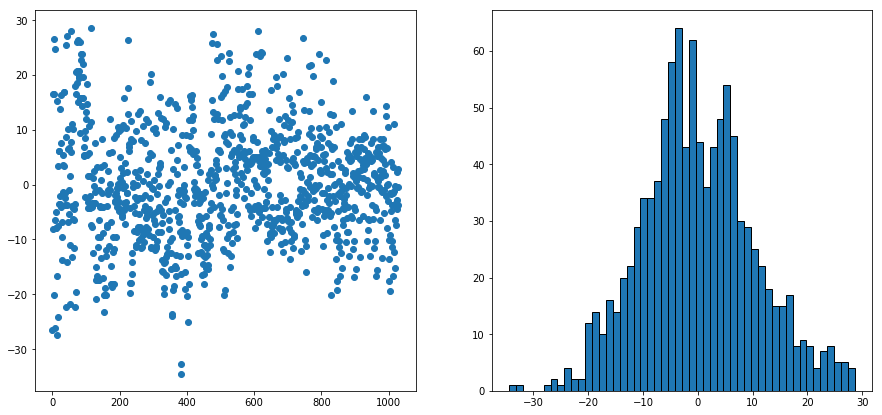

In [3]:
class LinearRegressionNE_numpy(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self.theta = None
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Fit call
    def fit(self,X,y,l2_reg=0.):
        # Add bias column
        X_bias = self._addBias(X)
        # Solve for theta
        inverse_hessian = np.linalg.inv(np.matmul(X_bias.T,X_bias) + l2_reg * np.eye(self.n_features+1))
        self.theta = np.dot(np.matmul(inverse_hessian,X_bias.T),y)
        return

# Define and plot model
lr = LinearRegressionNE_numpy(n_features=X.shape[1])
lr.fit(X,y)
print("RMSE: %.3e"%lr.score(X,y))
# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfNormal'></a>

---
---
---
# NORMAL EQUATIONS WITH TENSORFLOW

RMSE: 1.072e+02


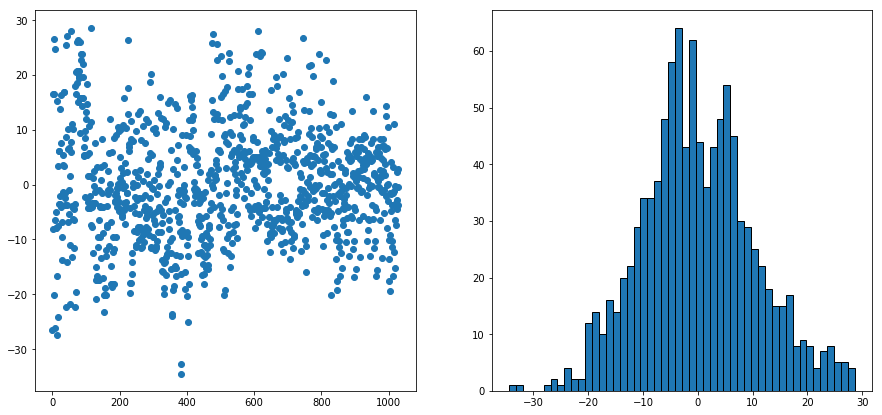

In [5]:
class LinearRegressionNE_tf(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            # Regularization parameter and matrix
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            self.regularizer = self.l2_reg * tf.eye(self.n_features+1)
            # Normal equations
            self.theta_op = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(self.X),self.X) + self.regularizer),
                                             tf.transpose(self.X)),self.y,name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Fit call
    def fit(self,X,y,l2_reg=0.):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and evaluate theta
        with self.graph.as_default():
            self.session = tf.Session()
            self.theta = self.theta_op.eval(session=self.session,feed_dict={self.X:X_bias,self.y:y,
                                                                            self.l2_reg:l2_reg})
        return

lr = LinearRegressionNE_tf(n_features=X.shape[1])
lr.fit(X,y)
print("RMSE: %.3e"%lr.score(X,y))

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDManual'></a>

---
---
---
# GRADIENT DESCENT WITH TENSORFLOW (MANUAL GRADIENTS)

Instructions for updating:
Colocations handled automatically by placer.
 4007 ** 1.072e+02 ** 0.000e+00
RMSE: 1.072e+02


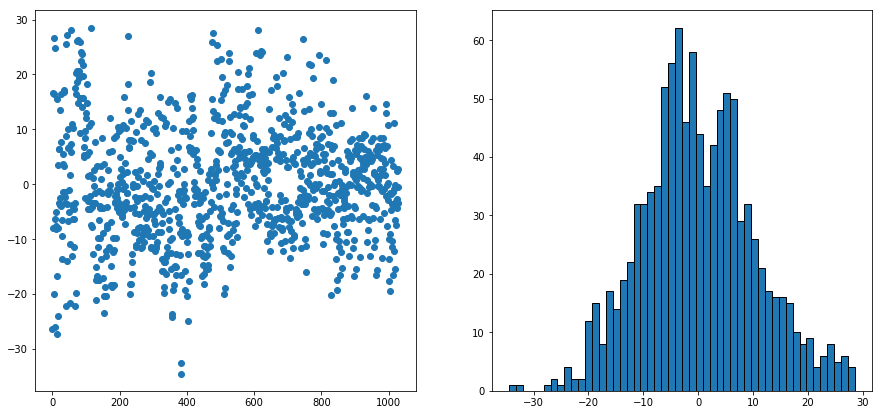

In [6]:
class LinearRegressionGD_tf_manual(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            # Regularization parameter
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            # Define gradients manually which are used to update the parameters theta_op
            self.gradient = (2./tf.cast(tf.shape(self.X)[0],tf.float32)) \
                            * (tf.matmul(tf.transpose(self.X),self.residuals) \
                               + self.l2_reg * tf.square(self.theta_op))
            # Define gradient update operation
            self.training_op = tf.assign(self.theta_op,self.theta_op - self.learning_rate * self.gradient)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Fit call
    def fit(self,X,y,l2_reg=0.,learning_rate=1e-3,max_iter=1000,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                self.training_op.eval(session=self.session,feed_dict=feed_dict)
                # Calculate loss and update delta and previous loss
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_manual(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-2)
print("RMSE: %.3e"%lr.score(X,y))

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDAuto'></a>

---
---
---
# GRADIENT DESCENT WITH TENSORFLOW (AUTODIFF)

 4159 ** 1.072e+02 ** 0.000e+00
RMSE: 1.072e+02


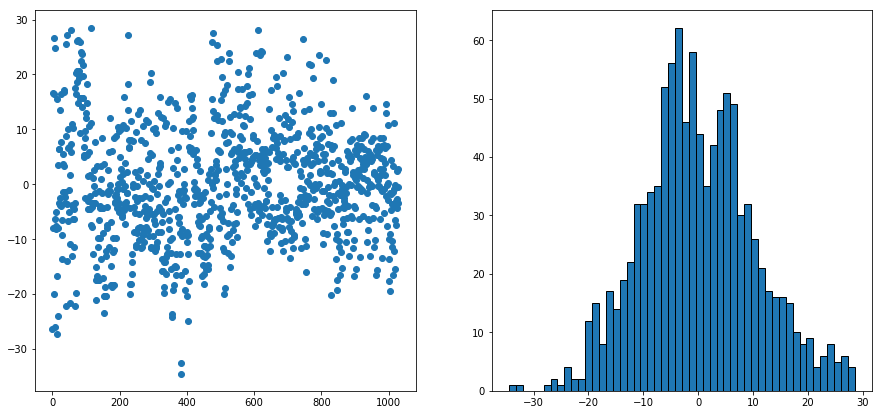

In [7]:
class LinearRegressionGD_tf_auto(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            # Regularization parameter
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            # Define regularization and total losses
            self.reg_loss = self.l2_reg * tf.reduce_mean(tf.square(self.theta_op))
            self.loss = self.rmse + self.reg_loss
            # Use automatic differentiation to calculate the gradient
            self.gradient = tf.gradients(self.loss,[self.theta_op])[0]
            # Define gradient update operation
            self.training_op = tf.assign(self.theta_op,self.theta_op - self.learning_rate * self.gradient)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Fit call
    def fit(self,X,y,l2_reg=0.,learning_rate=1e-3,max_iter=1000,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                self.training_op.eval(session=self.session,feed_dict=feed_dict)
                # Calculate loss and update delta and previous loss
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_auto(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-2)
print("RMSE: %.3e"%lr.score(X,y))

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDOptim'></a>

---
---
---

# GRADIENT DESCENT WITH TENSORFLOW (USING OPTIMIZER)

 1065 ** 1.072e+02 ** 0.000e+00
RMSE: 1.072e+02


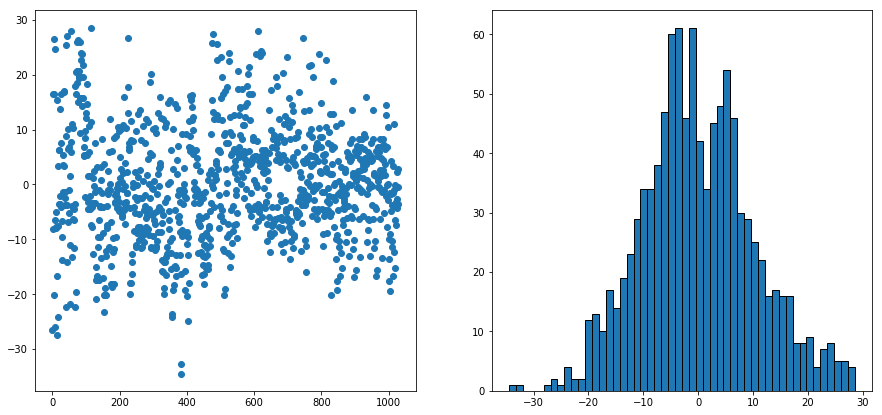

In [8]:
class LinearRegressionGD_tf_adam(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            # Regularization parameter
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            # Define regularization and total losses (L2)
            self.reg_loss = self.l2_reg * tf.reduce_mean(tf.square(self.theta_op))
            # L1 
            self.reg_loss = self.l2_reg * tf.reduce_mean(tf.square(self.theta_op))
            
            self.loss = self.rmse + self.reg_loss
            # Define optimizer and training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.training_op = self.optimizer.minimize(self.loss)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Fit call
    def fit(self,X,y,l2_reg=0.,learning_rate=1e-3,max_iter=1000,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                self.training_op.run(session=self.session,feed_dict=feed_dict)
                # Calculate loss and update delta and previous loss
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_adam(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-1)
print("RMSE: %.3e"%lr.score(X,y))

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDBatch'></a>


---
---
---

# GRADIENT DESCENT WITH TENSORFLOW (ADDING MINI-BATCHES)

As a reminder, mini-batches simply means that instead of training on all the data all at once, you run through pieces of it. One epoch implies you have run through all the mini-batches so that all the training data has been seen.

 1210 ** 1.077e+02 ** 0.000e+00
RMSE: 1.077e+02


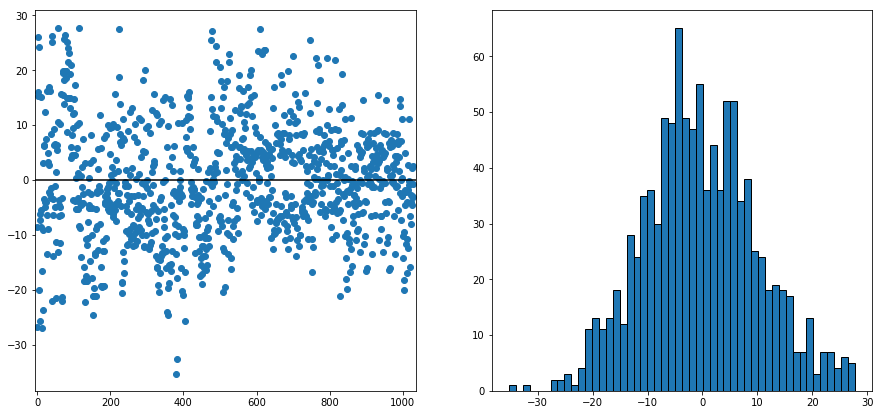

In [26]:
# BATCH GRADIENT DESCENT

class LinearRegressionGD_tf_adam_batch(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            # Regularization parameter
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            # Define regularization and total losses
            self.reg_loss = self.l2_reg * tf.reduce_mean(tf.square(self.theta_op))
            self.loss = self.rmse + self.reg_loss
            # Define optimizer and training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.training_op = self.optimizer.minimize(self.loss)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Get batches for each run, shuffling between epochs
    def getBatches(self,X,y,n_batches):
        n_data = X.shape[0]
        n_indices = np.arange(n_data)
        batch_size = int(np.floor(n_data/n_batches))
        np.random.shuffle(n_indices)
        X_batches = []
        y_batches = []
        
        for ii in range(n_batches):
            if ii<(n_batches-1):
                X_new = X[ii*batch_size:(ii*batch_size+batch_size),:]
                y_new = y[ii*batch_size:(ii*batch_size+batch_size),:]
            else:
                X_new = X[ii*batch_size:,:]
                y_new = y[ii*batch_size:,:]
            X_batches.append(X_new)
            y_batches.append(y_new)
            
        return X_batches, y_batches
        
    # Fit call
    def fit(self,X,y,l2_reg=0.,learning_rate=1e-3,max_iter=1000,n_batches=10,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                X_batches, y_batches = self.getBatches(X_bias,y,n_batches)
                
                for idx,X_batch in enumerate(X_batches):
                    y_batch = y_batches[idx]
                     # Define input dictionary
                    feed_dict={self.X:X_batch,self.y:y_batch,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
                    self.training_op.run(session=self.session,feed_dict=feed_dict)
                    
                    
                # Calculate loss and update delta and previous loss (using the entire batch)
                feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l2_reg:l2_reg}
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_adam_batch(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-1,n_batches=1,l2_reg=0.1)
print("RMSE: %.3e"%lr.score(X,y))

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax.plot([-5,len(y)+5],[0,0],c='k')
ax.set_xlim([-5,len(y)+5])
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDL1'></a>


---
---
---

# GRADIENT DESCENT WITH TENSORFLOW (L1 REGULARIZER)

Again, a reminder that the L1 regularizer goes as $\lambda_1 \sum \limits_i |\theta_i|$

 5000 ** 1.087e+02 ** 5.264e-04
RMSE: 1.087e+02
Number of zero parameters: 0


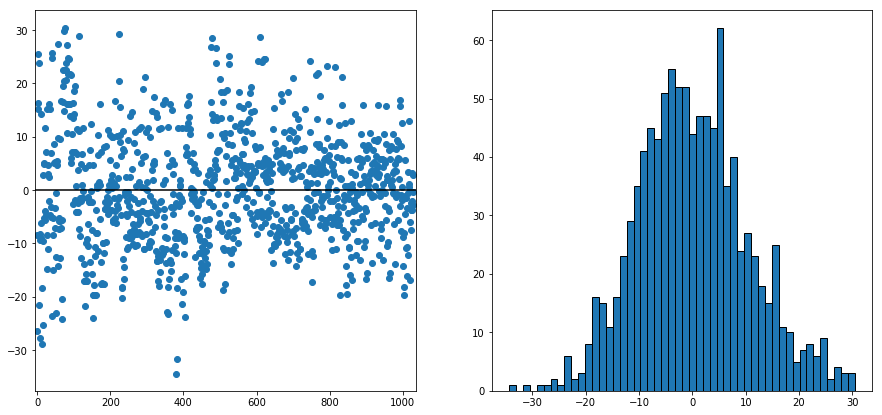

In [41]:
# BATCH GRADIENT DESCENT

class LinearRegressionGD_tf_adam_batch_l1(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            
            
            # Regularization parameter
            self.l1_reg = tf.placeholder(tf.float32,name='l1_reg')
            
            
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            
            
            # Define regularization and total losses (L1 now)
            self.reg_loss = self.l1_reg * tf.reduce_sum(tf.abs(self.theta_op))
            self.loss = self.rmse + self.reg_loss
            
            
            # Define optimizer and training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.training_op = self.optimizer.minimize(self.loss)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Get batches for each run, shuffling between epochs
    def getBatches(self,X,y,n_batches):
        n_data = X.shape[0]
        n_indices = np.arange(n_data)
        batch_size = int(np.floor(n_data/n_batches))
        np.random.shuffle(n_indices)
        X_batches = []
        y_batches = []
        
        for ii in range(n_batches):
            if ii<(n_batches-1):
                X_new = X[ii*batch_size:(ii*batch_size+batch_size),:]
                y_new = y[ii*batch_size:(ii*batch_size+batch_size),:]
            else:
                X_new = X[ii*batch_size:,:]
                y_new = y[ii*batch_size:,:]
            X_batches.append(X_new)
            y_batches.append(y_new)
            
        return X_batches, y_batches
        
    # Fit call
    def fit(self,X,y,l1_reg=0.,learning_rate=1e-3,max_iter=1000,n_batches=10,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l1_reg:l1_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                X_batches, y_batches = self.getBatches(X_bias,y,n_batches)
                
                for idx,X_batch in enumerate(X_batches):
                    y_batch = y_batches[idx]
                     # Define input dictionary
                    feed_dict={self.X:X_batch,self.y:y_batch,self.learning_rate:learning_rate,self.l1_reg:l1_reg}
                    self.training_op.run(session=self.session,feed_dict=feed_dict)
                    
                    
                # Calculate loss and update delta and previous loss (using the entire batch)
                feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l1_reg:l1_reg}
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_adam_batch_l1(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-1, n_batches=100,l1_reg = 0.1 )
print("RMSE: %.3e"%lr.score(X,y))

# Number of 0'd parameters
theta = lr.theta
zero_count = np.sum(np.isclose(theta,0,atol=1e-3))
print("Number of zero parameters: %d"%zero_count)

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax.plot([-5,len(y)+5],[0,0],c='k')
ax.set_xlim([-5,len(y)+5])
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()

<a id='tfGDElastic'></a>


---
---
---

# GRADIENT DESCENT WITH TENSORFLOW (ELASTIC NET)

This one should be easy, as it's just including both L1 and L2 regularizers.

 106 ** 1.090e+02 ** 0.000e+00
RMSE: 1.090e+02
Number of zero parameters: 0


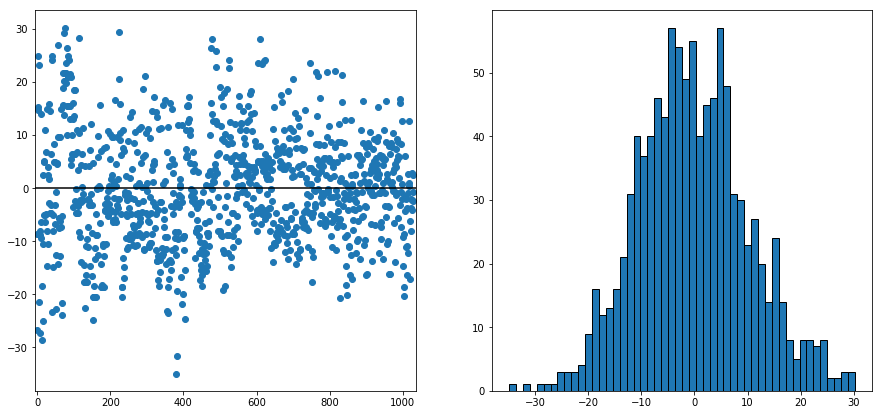

In [52]:
# BATCH GRADIENT DESCENT

class LinearRegressionGD_tf_adam_batch_elastic(object):
    def __init__(self,n_features):
        self.n_features = n_features
        self._buildGraph()
    # Build tensorflow graph
    def _buildGraph(self):
        # Define graph
        self.graph = tf.Graph()
        # Set the local graph as default and
        # add nodes to it
        with self.graph.as_default():
            # Placeholders for input matrix X and target y
            self.X = tf.placeholder(tf.float32,shape=[None,self.n_features+1],name='X')
            self.y = tf.placeholder(tf.float32,shape=[None,1],name='y')
            
            
            # Regularization parameters
            self.l1_reg = tf.placeholder(tf.float32,name='l1_reg')
            self.l2_reg = tf.placeholder(tf.float32,name='l2_reg')
            
            
            # Learning rate
            self.learning_rate = tf.placeholder(tf.float32,name='learning_rate')
            # Define parameters
            self.theta_op = tf.Variable(tf.random.normal([self.n_features+1,1]),name='theta')
            # Define rmse,residuals and predicted response
            self.ypred = tf.matmul(self.X,self.theta_op,name='ypred')
            self.residuals =  self.ypred - self.y
            self.rmse = tf.reduce_mean(tf.square(self.residuals),name='rmse')
            
            
            # Define regularization and total losses (L1 now)
            self.reg_loss_1 = self.l1_reg * tf.reduce_sum(tf.abs(self.theta_op))
            self.reg_loss_2 = self.l2_reg * tf.reduce_mean(tf.square(self.theta_op))
            self.loss = self.rmse + self.reg_loss_1 + self.reg_loss_2
            
            
            # Define optimizer and training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.training_op = self.optimizer.minimize(self.loss)
            # Define initializer (to initialize theta_op which is drawn from a random distribution)
            self.init = tf.global_variables_initializer()
        return
    # Add bias column to design matrix
    def _addBias(self,X):
        return np.concatenate((np.ones((len(X),1)),X),axis=1)
    # RMSE
    def score(self,X,y):
        return np.square(np.dot(self._addBias(X),self.theta) - y).mean()
    # Get residuals function
    def getResiduals(self,X,y):
        return np.dot(self._addBias(X),self.theta) - y
    # Get batches for each run, shuffling between epochs
    def getBatches(self,X,y,n_batches):
        n_data = X.shape[0]
        n_indices = np.arange(n_data)
        batch_size = int(np.floor(n_data/n_batches))
        np.random.shuffle(n_indices)
        X_batches = []
        y_batches = []
        
        for ii in range(n_batches):
            if ii<(n_batches-1):
                X_new = X[ii*batch_size:(ii*batch_size+batch_size),:]
                y_new = y[ii*batch_size:(ii*batch_size+batch_size),:]
            else:
                X_new = X[ii*batch_size:,:]
                y_new = y[ii*batch_size:,:]
            X_batches.append(X_new)
            y_batches.append(y_new)
            
        return X_batches, y_batches
        
    # Fit call
    def fit(self,X,y,l2_reg=0., l1_reg=0.,learning_rate=1e-3,max_iter=1000,n_batches=10,tol=1e-6):
        # Add bias column
        X_bias = self._addBias(X)
        # Start session and iterate
        with self.graph.as_default():
            # Define session
            self.session = tf.Session()
            # Initialize variables
            self.init.run(session=self.session)
            # Define input dictionary
            feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l1_reg:l1_reg,self.l2_reg:l2_reg}
            # Helper variables to check for convergence
            previous_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
            current_loss  = previous_loss 
            delta = tol + 1.
            epoch = 0
            
            while delta>tol and epoch<max_iter:
                # Update theta by calculating the gradients
                X_batches, y_batches = self.getBatches(X_bias,y,n_batches)
                
                for idx,X_batch in enumerate(X_batches):
                    y_batch = y_batches[idx]
                     # Define input dictionary
                    feed_dict={self.X:X_batch,self.y:y_batch,self.learning_rate:learning_rate,self.l1_reg:l1_reg,self.l2_reg:l2_reg}
                    self.training_op.run(session=self.session,feed_dict=feed_dict)
                    
                    
                # Calculate loss and update delta and previous loss (using the entire batch)
                feed_dict={self.X:X_bias,self.y:y,self.learning_rate:learning_rate,self.l1_reg:l1_reg,self.l2_reg:l2_reg}
                current_loss = self.rmse.eval(session=self.session,feed_dict=feed_dict)
                delta = np.abs(current_loss - previous_loss)
                previous_loss = current_loss
                epoch += 1
                
                print("\r %d ** %.3e ** %.3e"%(epoch,current_loss,delta),end='')
            # Evaluate best theta
            self.theta = self.theta_op.eval(session=self.session)
            print()
        return

lr = LinearRegressionGD_tf_adam_batch_elastic(n_features=X.shape[1])
lr.fit(X,y,max_iter=5000,learning_rate=1e-1, n_batches=100,l1_reg = 0.1, l2_reg=0.1 )
print("RMSE: %.3e"%lr.score(X,y))

# Number of 0'd parameters
theta = lr.theta
zero_count = np.sum(np.isclose(theta,0,atol=1e-3))
print("Number of zero parameters: %d"%zero_count)

# Plot residuals
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.plot(lr.getResiduals(X,y),lw=0,marker='o')
ax.plot([-5,len(y)+5],[0,0],c='k')
ax.set_xlim([-5,len(y)+5])
ax = fig.add_subplot(122)
ax.hist(lr.getResiduals(X,y),bins=50,edgecolor='black')
plt.show()